<a href="https://colab.research.google.com/github/fedhere/PUS2020_FBianco/blob/master/classdemo/GeospatialAnalysis_CitiBike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# reproducible Spatial Data Analysis with pandas
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

N.B. This workbook is based on one by SRK325. Choropleths and spatial join sections added by CMP670.

## Import initial libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
try:
    import ipywidgets as widgets
    hasWidgets = True
except ImportError:
    hasWidgets = False


In [3]:
!pip install geopandas

  Using cached https://files.pythonhosted.org/packages/f7/a4/e66aafbefcbb717813bf3a355c8c4fc3ed04ea1dd7feb2920f2f4f868921/geopandas-0.8.1-py2.py3-none-any.whl


In [2]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [3]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

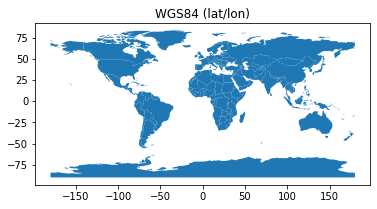

In [4]:
ax = world.plot()
ax.set_title("WGS84 (lat/lon)");



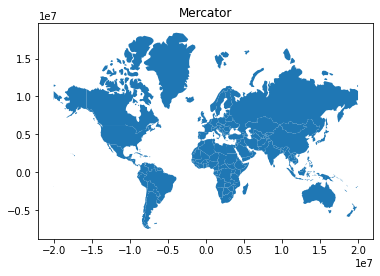

In [5]:
# Reproject to Mercator (after dropping Antartica)
world = world[(world.name != "Antarctica") & (world.name != "Fr. S. Antarctic Lands")]

world = world.to_crs("EPSG:3395") # world.to_crs(epsg=3395) would also work

ax = world.plot()

ax.set_title("Mercator");

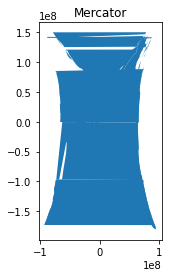

In [12]:
world = world[(world.name != "Antarctica") & (world.name != "Fr. S. Antarctic Lands")]

world = world.to_crs("EPSG:3407") # hong kong projection
ax = world.plot()

ax.set_title("Mercator");

In [36]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [5]:
world.set_index("name", inplace=True)
world

,pop_est,continent,iso_a3,gdp_md_est,geometry
name,,,,,
Fiji,920938,Oceania,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
Tanzania,53950935,Africa,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
W. Sahara,603253,Africa,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
Canada,35623680,North America,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
United States of America,326625791,North America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...
Serbia,7111024,Europe,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
Montenegro,642550,Europe,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
Kosovo,1895250,Europe,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."


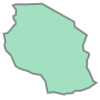

In [7]:
# a polygon
world.loc["Tanzania", "geometry"]

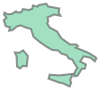

In [8]:
# a multipolygon
world.loc["Italy", "geometry"]

## Working with Shape File

### Loading Census Tract Shape File¶

In [6]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
cd /content/drive/Shared\ drives/PUS2020

/content/drive/Shared drives/PUS2020


In [8]:
ls data

'2010 Census Tracts'/
 201903-citibike-tripdata.csv.zip
 201904-citibike-tripdata.csv.zip
 201905-citibike-tripdata.csv.zip
 201906-citibike-tripdata.csv.zip
 202003-citibike-tripdata.csv.zip
 202004-citibike-tripdata.csv.zip
 202005-citibike-tripdata.csv.zip
 202006-citibike-tripdata.csv.zip
 arrest_data_daily_by_zip.csv
 citibike/
 citibikes_monthly.csv
 Longitude_Graticules_and_World_Countries_Boundaries-shp/
 MapPLUTO.cpg
 MapPLUTO.dbf
 MapPLUTO.prj
 MapPLUTO.sbn
 MapPLUTO.sbx
 MapPLUTO.shp
 MapPLUTO.shp.xml
 MapPLUTO.shx
 MNMapPLUTO.dbf
 MNMapPLUTO.prj
 MNMapPLUTO.sbn
 MNMapPLUTO.sbx
 MNMapPLUTO.shp
 MNMapPLUTO.shp.xml
 MNMapPLUTO.shx
 natural_earth_vector/
 PLUTODD20v5.pdf
 PlutoReadme20v5.pdf
 PPR_Properties.csv
 Varnamesnlabels_m2ihip_R.xlsx
 Varnamesnlabels_m2ihip.xlsx


In [9]:
ls "data/2010 Census Tracts"

geo_export_342ef674-8015-48e8-b6a4-611ab0993e4f.dbf
geo_export_342ef674-8015-48e8-b6a4-611ab0993e4f.prj
geo_export_342ef674-8015-48e8-b6a4-611ab0993e4f.shp
geo_export_342ef674-8015-48e8-b6a4-611ab0993e4f.shx


In [10]:
shape_path = "data/2010 Census Tracts/geo_export_342ef674-8015-48e8-b6a4-611ab0993e4f.shp"
ct_shape = gpd.GeoDataFrame.from_file(shape_path)
ct_shape.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((-74.07921 40.64343, -74.07914 40.643..."
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((-73.96433 40.75638, -73.96479 40.755..."
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((-73.96802 40.75958, -73.96848 40.758..."
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((-73.97124 40.76094, -73.97170 40.760..."
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,"POLYGON ((-73.97446 40.76229, -73.97491 40.761..."


In [11]:
ct_shape.describe()

,shape_area,shape_leng
count,2.165000e+03,2165.000000
mean,3.891504e+06,8727.346925
std,7.952934e+06,8421.790925
min,4.478076e+05,2816.869532
25%,1.683689e+06,5622.863766
50%,1.987938e+06,6496.952057
75%,3.192228e+06,8734.805687
max,1.966297e+08,182384.827557


### Coordinate systems, projections, and transformations 

conver to EPSG 2263 which is coordinated in feet, instead of lat long degrees

extract the area of each gemetry : the geometry column has many relevant methods

calculate the total area in miles squared. the feet to meter conversion is here 
https://www.google.com/search?sxsrf=ALeKk03B4ThQrJJXpFzoCrgRfrJ1nByPMg%3A1600870977934&ei=QVprX9muOIOl_QbOtaOwCQ&q=feet+to+mile&oq=feet+to+mile&gs_lcp=CgZwc3ktYWIQAzIICAAQsQMQkQIyAggAMgIIADICCAAyAggAMgIIADICCAAyAggAMgIIADICCAA6BAgAEEc6BAgjECc6BQgAELEDOgoIABCxAxAUEIcCUM_1AVjK-AFgzPoBaABwAngAgAFkiAHvApIBAzMuMZgBAKABAaoBB2d3cy13aXrIAQjAAQE&sclient=psy-ab&ved=0ahUKEwiZ0-GPvf_rAhWDUt8KHc7aCJYQ4dUDCA0&uact=5

can you do it in 1 line?

In [27]:
from fiona.crs import from_epsg


In [ ]:
...
print ('total NYC land area: {:.0f} (mi^2)'.format(NYC_Area)) # from ft2 to mi2 #epsg=2263 is US feet

### Visualize the Census Tract boundaries colored by boroughs

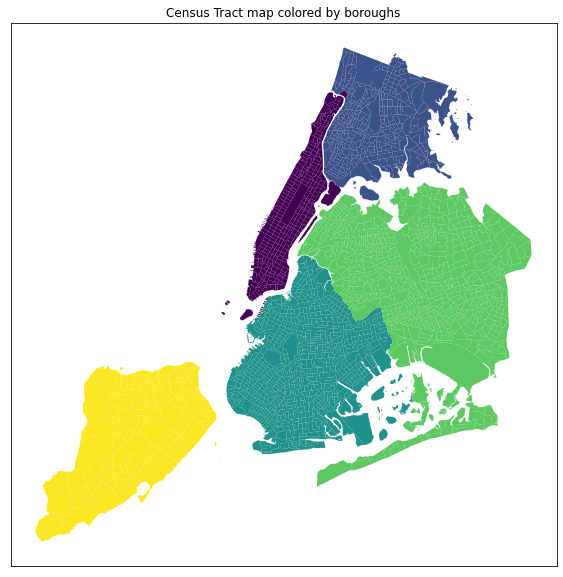

In [16]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='boro_code',alpha=1,linewidth=0.5,ax=ax, cmap='viridis')
plt.title("Census Tract map colored by boroughs");

### Map ct area

#### Vusualize the ct area

In [17]:
ct_shape.to_crs(epsg=2263).head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((962269.126 173705.500, 962288.722 17..."
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((994133.507 214848.898, 994005.909 21..."
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((993108.306 216013.131, 992982.220 21..."
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((992216.539 216507.687, 992091.031 21..."
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,"POLYGON ((991325.882 217001.689, 991199.221 21..."


In [12]:
ct_shape['shape_areainmi2'] = ct_shape.to_crs(epsg=2263).geometry.area / (2.788*10**7)


In [19]:
ct_shape.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry,shape_areainmi2
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((-74.07921 40.64343, -74.07914 40.643...",0.089563
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((-73.96433 40.75638, -73.96479 40.755...",0.068365
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((-73.96802 40.75958, -73.96848 40.758...",0.066748
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((-73.97124 40.76094, -73.97170 40.760...",0.066750
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,"POLYGON ((-73.97446 40.76229, -73.97491 40.761...",0.066879


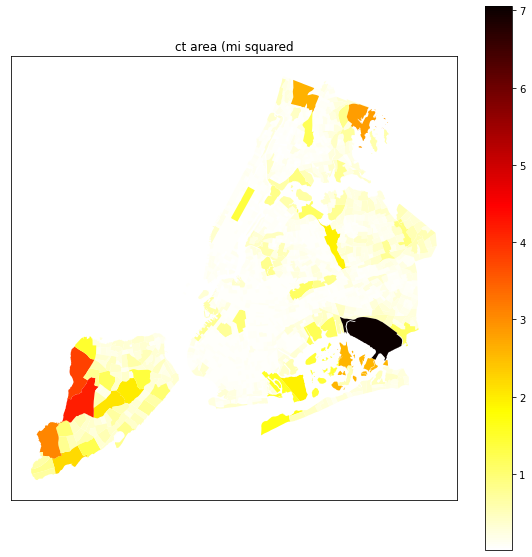

In [13]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='shape_areainmi2',cmap='hot_r',alpha=1,linewidth=0.1,ax=ax, legend=True)
plt.title("ct area (mi squared");

## Choropleths

In [21]:
!pip install -U --no-deps mapclassify git+git://github.com/geopandas/geopandas.git@master


  Cloning git://github.com/geopandas/geopandas.git (to revision master) to /tmp/pip-req-build-dkj2o8ds
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-dkj2o8ds
Requirement already up-to-date: mapclassify in /usr/local/lib/python3.6/dist-packages (2.3.0)
  Created wheel for geopandas: filename=geopandas-0.8.0+40.gcb4e8cb-py2.py3-none-any.whl size=963639 sha256=be0c14b42e3425efff93fee3a14f366c463d7f02b73ea288d9689d590d008d6b
  Stored in directory: /tmp/pip-ephem-wheel-cache-82ix5zal/wheels/1e/57/dc/7a5ea8503aefb23576c42181adfca7fc173fde5b71900660bc
Successfully built geopandas
  Found existing installation: geopandas 0.8.1
    Uninstalling geopandas-0.8.1:
      Successfully uninstalled geopandas-0.8.1


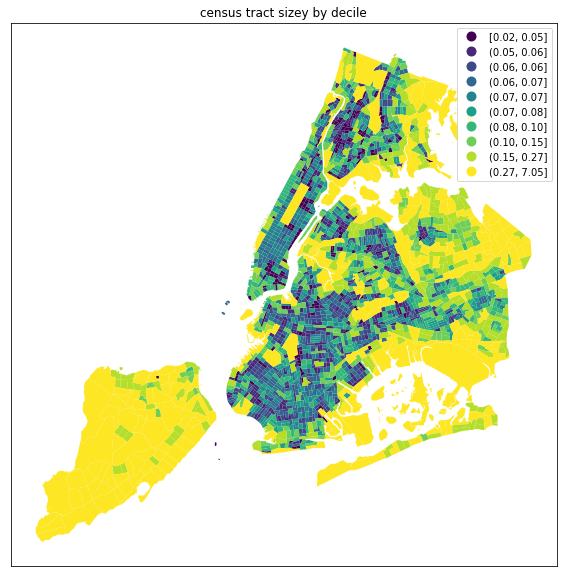

In [14]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='shape_areainmi2',cmap='viridis',alpha=1,
                  linewidth=0.1,ax=ax, scheme="quantiles", legend=True, k=10)
plt.title("census tract sizey by decile");

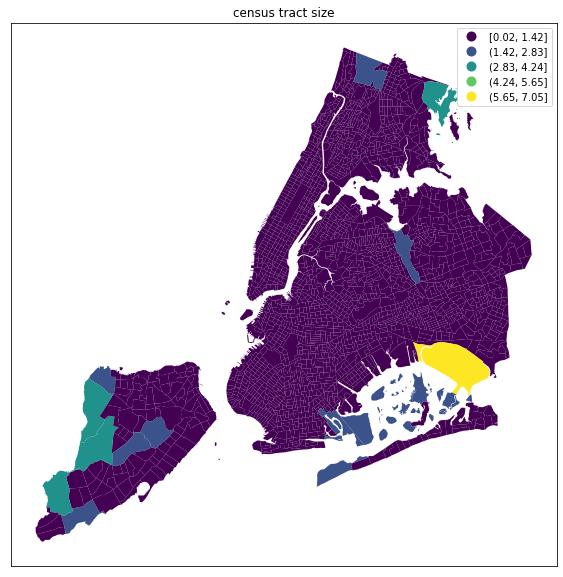

In [17]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='shape_areainmi2',cmap='viridis',alpha=1,linewidth=0.1,ax=ax, 
                  scheme="Equal_interval", legend=True, k=5)
plt.title("census tract size");

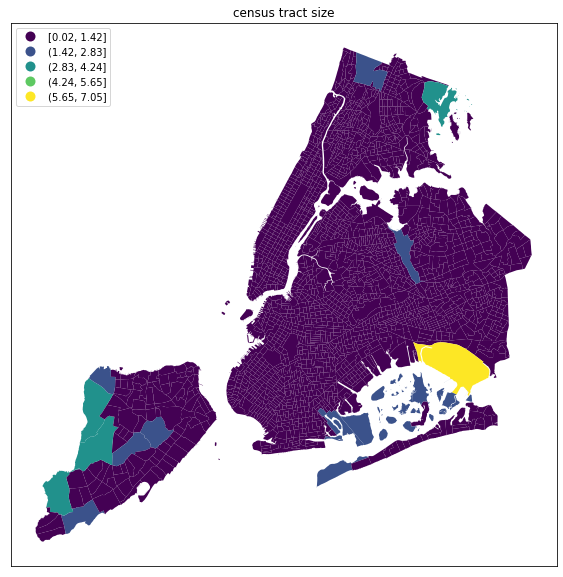

In [16]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='shape_areainmi2',cmap='viridis',alpha=1,linewidth=0.1,ax=ax, 
                  scheme="Equal_interval", legend=True, k=5, legend_kwds={'loc': 'upper left'});
plt.title("census tract size");

# https://github.com/fedhere/choroplethNYC

## Explore CitiBike data

### Load CitiBike data

In [15]:
cb201309 = pd.read_csv('https://s3.amazonaws.com/tripdata/201309-citibike-tripdata.zip', index_col='starttime')
cb201309.head()

,tripduration,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
starttime,,,,,,,,,,,,,,
2013-09-01 00:00:02,1010,2013-09-01 00:16:52,254,W 11 St & 6 Ave,40.735324,-73.998004,147,Greenwich St & Warren St,40.715422,-74.011220,15014,Subscriber,1974,1
2013-09-01 00:00:09,1443,2013-09-01 00:24:12,151,Cleveland Pl & Spring St,40.721816,-73.997203,497,E 17 St & Broadway,40.737050,-73.990093,19393,Customer,\N,0
2013-09-01 00:00:16,1387,2013-09-01 00:23:23,352,W 56 St & 6 Ave,40.763406,-73.977225,405,Washington St & Gansevoort St,40.739323,-74.008119,16160,Subscriber,1992,1
2013-09-01 00:00:18,405,2013-09-01 00:07:03,490,8 Ave & W 33 St,40.751551,-73.993934,459,W 20 St & 11 Ave,40.746745,-74.007756,14997,Subscriber,1973,1
2013-09-01 00:00:20,270,2013-09-01 00:04:50,236,St Marks Pl & 2 Ave,40.728419,-73.987140,393,E 5 St & Avenue C,40.722992,-73.979955,19609,Subscriber,1984,1


In [20]:
cb201309.index = pd.to_datetime(cb201309.index)

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [16]:
cb201309.groupby("start station id").first()

,tripduration,stoptime,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
start station id,,,,,,,,,,,,,
72,143,2013-09-01 01:29:19,W 52 St & 11 Ave,40.767272,-73.993929,367,E 53 St & Lexington Ave,40.758281,-73.970694,16521,Subscriber,1960,1
79,1049,2013-09-01 00:37:46,Franklin St & W Broadway,40.719116,-74.006667,363,West Thames St,40.708347,-74.017134,17660,Customer,\N,0
82,437,2013-09-01 12:09:47,St James Pl & Pearl St,40.711174,-74.000165,151,Cleveland Pl & Spring St,40.721816,-73.997203,19046,Subscriber,1980,2
83,857,2013-09-01 00:57:59,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,406,Hicks St & Montague St,40.695128,-73.995951,19618,Subscriber,1977,2
116,468,2013-09-01 00:13:46,W 17 St & 8 Ave,40.741776,-74.001497,540,Lexington Ave & E 26 St,40.741473,-73.983209,17346,Subscriber,1991,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,266,2013-09-01 00:08:15,E 43 St & 2 Ave,40.750224,-73.971214,228,E 48 St & 3 Ave,40.754601,-73.971879,18462,Subscriber,1981,1
2021,1727,2013-09-01 01:05:25,W 45 St & 8 Ave,40.759291,-73.988597,218,Gallatin Pl & Livingston St,40.690284,-73.987071,16734,Customer,\N,0
2022,1233,2013-09-01 00:39:20,E 59 St & Sutton Pl,40.758491,-73.959206,528,2 Ave & E 31 St,40.742909,-73.977061,19488,Subscriber,1961,2


In [17]:
station_id = cb201309.groupby("start station id").first()[["start station latitude","start station longitude"]]
station_id.rename({"start station latitude":"lat","start station longitude":"lon"}, axis=1, inplace=True)
#station_id.index = station_id.index.astype(str)
station_id.head()

,lat,lon
start station id,,
72,40.767272,-73.993929
79,40.719116,-74.006667
82,40.711174,-74.000165
83,40.683826,-73.976323
116,40.741776,-74.001497


### Create CitiBike station Geometry (Point) from Coordinates (Lat & Lon)

In [18]:
import shapely
# combine lat and lon to one column
station_id['lonlat'] = list(zip(station_id.lon,station_id.lat))
# Create Point Geometry for based on lonlat column
station_id['geometry'] = station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
start station id,,,,
72,40.767272,-73.993929,"(-73.99392888, 40.76727216)",POINT (-73.99392888 40.76727216)
79,40.719116,-74.006667,"(-74.00666661, 40.71911552)",POINT (-74.00666661 40.71911552)
82,40.711174,-74.000165,"(-74.00016545, 40.71117416)",POINT (-74.00016545 40.71117416)
83,40.683826,-73.976323,"(-73.97632328, 40.68382604)",POINT (-73.97632328 40.68382604)
116,40.741776,-74.001497,"(-74.00149746, 40.74177603)",POINT (-74.00149746 40.74177603)


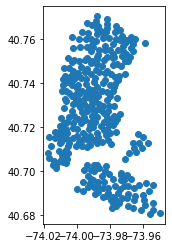

In [60]:
station_id.plot()

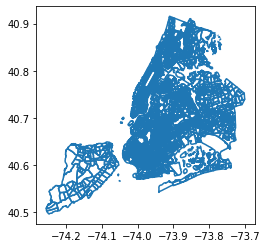

In [75]:
ct_shape.boundary.plot()

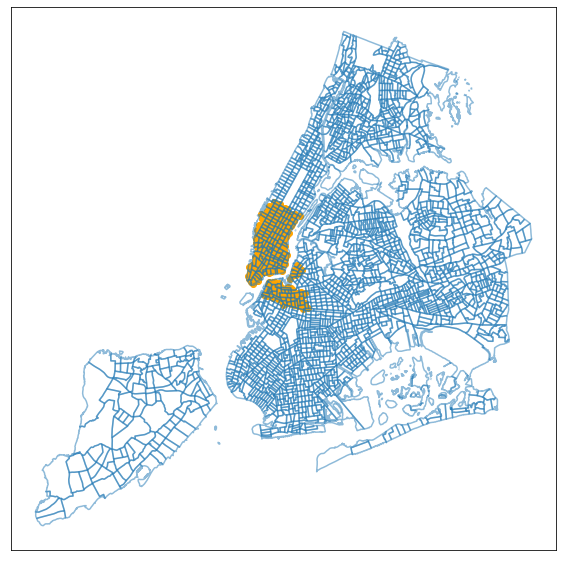

In [81]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.boundary.plot(ax=ax, alpha=0.5)
station_id.plot(ax=ax, c='orange');

(40.65, 40.78)

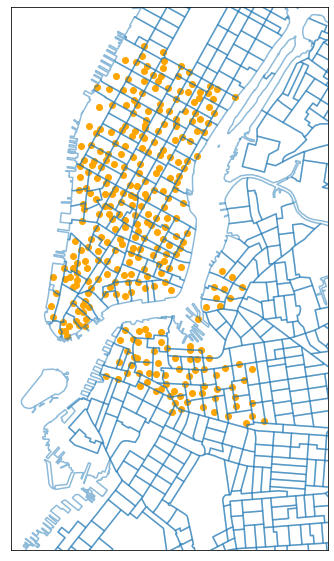

In [87]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.boundary.plot(ax=ax, alpha=0.5)
station_id.plot(ax=ax, c='orange');
ax.set_xlim(-74.03, -73.93)
ax.set_ylim(40.65, 40.78)

### Intersect the two geometries
# gdp.ct_shape.geometry.intersect



In [19]:
a=[]
#setup a progressbar
if hasWidgets:
    pb = widgets.FloatProgress(min=0, max=1, description="Creating pts:")
    display(pb)
step = 0.05
updatestep = 0
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].boro_ct201.values[0])
    progress = (i+1)/len(station_id)
    curstep = progress//step
    if hasWidgets:
        pb.value = progress
    elif updatestep!=curstep:
        # should use /r, but this is currently broken in jupyterlab, see https://github.com/jupyterlab/jupyterlab/issues/5326
        print ('{:.0f}%'.format(progress*100), end=" ")
        updatestep=curstep
station_id['boro_ct201'] = a
if hasWidgets: pb.description = "Done!"
else: print ("100%")

FloatProgress(value=0.0, description='Creating pts:', max=1.0)

In [21]:
station_id.head()

,lat,lon,lonlat,geometry,boro_ct201
start station id,,,,,
72,40.767272,-73.993929,"(-73.99392888, 40.76727216)",POINT (-73.99392888 40.76727216),1013500
79,40.719116,-74.006667,"(-74.00666661, 40.71911552)",POINT (-74.00666661 40.71911552),1003300
82,40.711174,-74.000165,"(-74.00016545, 40.71117416)",POINT (-74.00016545 40.71117416),1002500
83,40.683826,-73.976323,"(-73.97632328, 40.68382604)",POINT (-73.97632328 40.68382604),3003500
116,40.741776,-74.001497,"(-74.00149746, 40.74177603)",POINT (-74.00149746 40.74177603),1008300


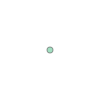

In [22]:
# a point
station_id.geometry.iloc[0]

## Perform a spatial join

Perfoming an $n \times m$ intersection test is horrifically inefficient and slow. Spatial joins use an R-tree for spatial indexing to rapidly join the tables on their geometries. 

Spatial joins operate on objects with eastings and northings, i.e., you must transform ALL data into a common CRS expressed with dimensioned lengths. This will NOT work on data expressed in lat/long!

In [23]:
from geopandas.tools import sjoin

In [24]:
station_id = gpd.GeoDataFrame(station_id)

In [25]:
#I just created the gDF. it does not have a set of coordinates associated to the shapes!
station_id.crs 

In [28]:
# set the initial lat-lon coordinates
station_id.crs = from_epsg(4326)
ct_shape.crs

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [29]:
station_ft = station_id.to_crs(epsg=2263)
ct_ft = ct_shape.to_crs(epsg=2263)

In [51]:
!apt install python3-rtree 


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 11 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-pkg-resources all 39.0.1-2 [98.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 k

In [90]:
ct_ft.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry,shape_areainmi2
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((962269.126 173705.500, 962288.722 17...",0.089563
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((994133.507 214848.898, 994005.909 21...",0.068365
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((993108.306 216013.131, 992982.220 21...",0.066748
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((992216.539 216507.687, 992091.031 21...",0.066750
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,"POLYGON ((991325.882 217001.689, 991199.221 21...",0.066879


In [105]:
sjoin(ct_ft, station_ft)


,boro_code,boro_ct201_left,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry,shape_areainmi2,index_right,lat,lon,lonlat,boro_ct201_right
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((994133.507 214848.898, 994005.909 21...",0.068365,454,40.754557,-73.965930,"(-73.96592976, 40.75455731)",1009800
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((994133.507 214848.898, 994005.909 21...",0.068365,441,40.756014,-73.967416,"(-73.967416, 40.756014)",1009800
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((993108.306 216013.131, 992982.220 21...",0.066748,522,40.757148,-73.972078,"(-73.97207836, 40.75714758)",1010000
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((993108.306 216013.131, 992982.220 21...",0.066748,367,40.758281,-73.970694,"(-73.97069431, 40.75828065)",1010000
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((993108.306 216013.131, 992982.220 21...",0.066748,2023,40.759681,-73.970314,"(-73.97031366, 40.75968085)",1010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2089,1,1001800,Manhattan,I,001800,18,MN27,Chinatown,3809,2.399275e+06,6391.921884,"POLYGON ((987062.275 201781.687, 987099.571 20...",0.086057,473,40.721101,-73.991925,"(-73.99192540000001, 40.72110063)",1001800
2089,1,1001800,Manhattan,I,001800,18,MN27,Chinatown,3809,2.399275e+06,6391.921884,"POLYGON ((987062.275 201781.687, 987099.571 20...",0.086057,311,40.717227,-73.988021,"(-73.98802084, 40.7172274)",1001800
2090,1,1004100,Manhattan,E,004100,41,MN24,SoHo-TriBeCa-Civic Center-Little Italy,3810,2.058614e+06,5913.870664,"POLYGON ((985969.727 201933.578, 985907.954 20...",0.073838,263,40.717290,-73.996375,"(-73.996375, 40.717290000000006)",1004100
2090,1,1004100,Manhattan,E,004100,41,MN24,SoHo-TriBeCa-Civic Center-Little Italy,3810,2.058614e+06,5913.870664,"POLYGON ((985969.727 201933.578, 985907.954 20...",0.073838,151,40.721816,-73.997203,"(-73.99720307, 40.7218158)",1004100


# count trips by census tract

In [127]:
montlytrips = cb201309.groupby("start station id").count()[["tripduration"]].rename({"tripduration":"MonthlyAve"}, axis=1)
montlytrips.head()

,MonthlyAve
start station id,
72,3153
79,2616
82,1393
83,1689
116,5982


In [129]:
station_id = station_id.join(pd.Series(montlytrips.MonthlyAve))

In [130]:
station_id.head()

,lat,lon,lonlat,geometry,boro_ct201,tripduration,MonthlyAve
start station id,,,,,,,
72,40.767272,-73.993929,"(-73.99392888, 40.76727216)",POINT (-73.99393 40.76727),1013500,3153,3153
79,40.719116,-74.006667,"(-74.00666661, 40.71911552)",POINT (-74.00667 40.71912),1003300,2616,2616
82,40.711174,-74.000165,"(-74.00016545, 40.71117416)",POINT (-74.00017 40.71117),1002500,1393,1393
83,40.683826,-73.976323,"(-73.97632328, 40.68382604)",POINT (-73.97632 40.68383),3003500,1689,1689
116,40.741776,-74.001497,"(-74.00149746, 40.74177603)",POINT (-74.00150 40.74178),1008300,5982,5982


In [131]:
station_id.groupby("boro_ct201").sum()

,lat,lon,tripduration,MonthlyAve
boro_ct201,,,,
1000202,122.139540,-221.945671,4809,4809
1000600,122.138696,-221.969594,5817,5817
1000700,284.940680,-518.057100,19521,19521
1000800,81.424829,-147.986943,2817,2817
1000900,122.107424,-222.036744,5466,5466
...,...,...,...,...
3054900,81.423304,-147.931154,1908,1908
3055100,40.712605,-73.962644,1154,1154
3055300,40.715348,-73.960241,2665,2665


### Add Monthly rides to the station GeoDataFrame with CT code

### Add the monthly average rides to the CT shapefile 

In [132]:
tripsbyct = ct_shape.merge(station_id.groupby("boro_ct201").sum().drop(["lat", "lon"], axis=1), 
                           left_on="boro_ct201", right_index=True)
tripsbyct.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry,shape_areainmi2,tripduration,MonthlyAve
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((-73.96433 40.75638, -73.96479 40.755...",0.068365,3986,3986
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((-73.96802 40.75958, -73.96848 40.758...",0.066748,7208,7208
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((-73.97124 40.76094, -73.97170 40.760...",0.066750,4898,4898
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,"POLYGON ((-73.97446 40.76229, -73.97491 40.761...",0.066879,6609,6609
5,1,1011300,Manhattan,I,011300,113,MN17,Midtown-Midtown South,3807,1.890907e+06,5699.860641,"POLYGON ((-73.98412 40.75484, -73.98460 40.754...",0.067823,19212,19212


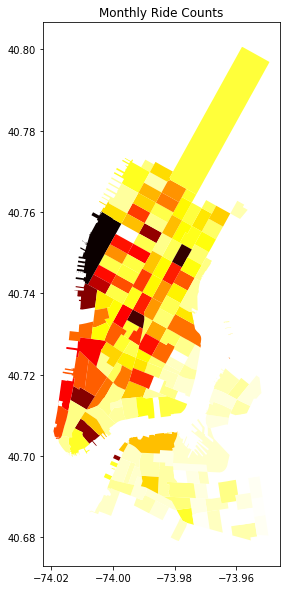

In [133]:
f, ax = plt.subplots(figsize=(10,10))
tripsbyct.plot(column='MonthlyAve',cmap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts");

### Removing the CTs that are out of zoom boundries

In [143]:
ct_shape_MonthlyAve_Zoom = tripsbyct[tripsbyct.MonthlyAve>10]
ct_shape_MonthlyAve_Zoom.crs
ct_shape_MonthlyAve_Zoom.to_crs(epsg="2263")

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry,shape_areainmi2,tripduration,MonthlyAve
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((994133.507 214848.898, 994005.909 21...",0.068365,3986,3986
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((993108.306 216013.131, 992982.220 21...",0.066748,7208,7208
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((992216.539 216507.687, 992091.031 21...",0.066750,4898,4898
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,"POLYGON ((991325.882 217001.689, 991199.221 21...",0.066879,6609,6609
5,1,1011300,Manhattan,I,011300,113,MN17,Midtown-Midtown South,3807,1.890907e+06,5699.860641,"POLYGON ((988650.277 214286.402, 988517.806 21...",0.067823,19212,19212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2062,1,1006000,Manhattan,I,006000,60,MN50,Stuyvesant Town-Cooper Village,3808,1.304407e+06,6260.705669,"MULTIPOLYGON (((994980.207 205295.575, 994980....",0.046786,7216,7216
2063,1,1006400,Manhattan,I,006400,64,MN21,Gramercy,3808,1.934408e+06,5564.012569,"POLYGON ((990332.258 207988.157, 990196.892 20...",0.069383,4456,4456
2089,1,1001800,Manhattan,I,001800,18,MN27,Chinatown,3809,2.399275e+06,6391.921884,"POLYGON ((987062.275 201781.687, 987099.571 20...",0.086057,13828,13828
2090,1,1004100,Manhattan,E,004100,41,MN24,SoHo-TriBeCa-Civic Center-Little Italy,3810,2.058614e+06,5913.870664,"POLYGON ((985969.727 201933.578, 985907.954 20...",0.073838,11145,11145


In [144]:
print ('Total number of CTs: {}'.format(len(ct_shape)))
print ('Number of zoomed CTs: {}'.format(len(ct_shape_MonthlyAve_Zoom.MonthlyAve)))

Total number of CTs: 2165
Number of zoomed CTs: 163


### Map the monthly rides 

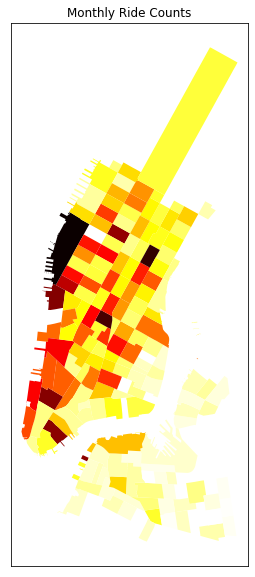

In [145]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAve',cmap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts");

### Export Shapefile CTs in the CitiBike Zone

In [147]:
%mkdir Output

mkdir: cannot create directory ‘Output’: File exists


In [148]:
path = 'Output/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  
